In [27]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as scp
from scipy import interpolate
from scipy.linalg import null_space

In [28]:
dx = 0.05
N_buff = 2
#buffer zone:
xbuffer,zbuffer = np.meshgrid(np.arange(-dx*N_buff-1,1+dx*(N_buff+1),dx),np.arange(-dx*N_buff-1,dx*N_buff+dx*0.5,dx))
nx_tot =xbuffer.shape[0]
nz_tot = zbuffer.shape[1]

Xbuffer1 = xbuffer[:,0:N_buff].reshape((nx_tot*N_buff,1))
Xbuffer2 = xbuffer[-N_buff:,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Xbuffer3 = xbuffer[0:N_buff,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Xbuffer4 = xbuffer[N_buff:-N_buff,-N_buff:].reshape(((nx_tot-2*N_buff)*N_buff,1))
Xbuffer = np.concatenate((Xbuffer1,Xbuffer2,Xbuffer3,Xbuffer4))
Zbuffer1 = zbuffer[:,0:N_buff].reshape((nx_tot*N_buff,1))
Zbuffer2 = zbuffer[-N_buff:,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Zbuffer3 = zbuffer[0:N_buff,N_buff:].reshape(((nz_tot-N_buff)*N_buff,1))
Zbuffer4 = zbuffer[N_buff:-N_buff,-N_buff:].reshape(((nx_tot-2*N_buff)*N_buff,1))
Zbuffer = np.concatenate((Zbuffer1,Zbuffer2,Zbuffer3,Zbuffer4))

N_buffer = Xbuffer.shape[0]


#interior points
x,z = np.meshgrid(np.arange(0,2+dx,dx),np.arange(0,1+dx,dx))
n = x.shape[0]
m = x.shape[1]

ni = n-2
mi = m-2
xi = x[1:-1,1:-1].reshape((ni*mi,1))
zi = z[1:-1,1:-1].reshape((ni*mi,1))



xo = np.zeros((n*2 + 2*(m-2),1))
zo = np.zeros((n*2 + 2*(m-2),1))
xo[0:n,0] = x[:,0]
zo[0:n,0] = z[:,0]

xo[n:2*n,0] = x[:,-1]
zo[n:2*n,0] = z[:,-1]

xo[2*n:2*n+m-2,0] = x[0,1:-1]
zo[2*n:2*n+m-2,0] = z[0,1:-1]
xo[2*n+m-2:,0] = x[-1,1:-1]
zo[2*n+m-2:,0] = z[-1,1:-1]

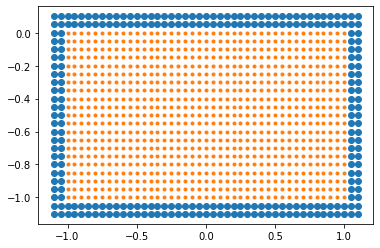

In [29]:
#ordering boundary points
xo = np.zeros((n*2 + 2*(m-2),1))
zo = np.zeros((n*2 + 2*(m-2),1))
xo[0:n,0] = x[:,0]
zo[0:n,0] = z[:,0]
xo[n:n+m-2,0] = x[-1,1:-1]
zo[n:n+m-2,0] = z[-1,1:-1]
xo[n+m-2:2*n+m-2,0] = np.flipud(x[:,-1])
zo[n+m-2:2*n+m-2,0] = np.flipud(z[:,-1])
xo[2*n+m-2:,0] = np.flipud(x[0,1:-1])
zo[2*n+m-2:,0] = np.flipud(z[0,1:-1])
X = np.concatenate((xi,xo)) -1
Z = np.concatenate((zi,zo)) -1
plt.plot(Xbuffer,Zbuffer,'o')
plt.plot(X,Z,'.')


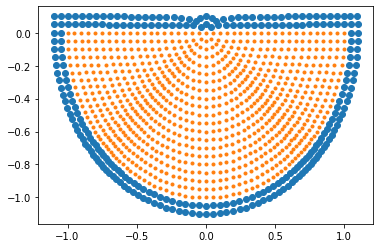

In [30]:
#converting into circle coordinates
#Xc = X #0.5*np.sin(X) #+X*np.sqrt(1-Z**2/2) 
#Zc = Z +np.sin(Xc*5)*0.2#Z*np.sqrt(1-X**2/2) 
#Xc = X*np.sqrt(1-Z**2/2) 
#Zc = Z*np.sqrt(1-X**2/2)  #+ 0.2*np.sin(2*X)*(1+Z)**2
r = np.maximum(np.abs(X),np.abs(Z))
theta = np.arctan2(Z,X)
Xc = r*np.cos(theta)
Zc = r*np.sin(theta)
#buffer coordinates:
r = np.maximum(np.abs(Xbuffer),np.abs(Zbuffer))
theta = np.arctan2(Zbuffer,Xbuffer)
Xb = r*np.cos(theta)
Zb = r*np.sin(theta)

xoc = Xc[ni*mi:,:]
zoc = Zc[ni*mi:,:]

#calculating boundary normals
xoc_normal = xoc*0
zoc_normal = zoc*0
xoc_normal[1:-1,0] = -zoc[2:,0]+zoc[0:-2,0]
zoc_normal[1:-1,0] = xoc[2:,0]-xoc[0:-2,0]

#boundary points
zoc_normal[0,0] = xoc[1,0] - xoc[-1,0]
xoc_normal[0,0] = -zoc[1,0] + zoc[-1,0]
zoc_normal[-1,0] = xoc[0,0] - xoc[-2,0]
xoc_normal[-1,0] = -zoc[0,0] + zoc[-2,0]


plt.plot(Xb,Zb,'o')
plt.plot(Xc,Zc,'.')

In [31]:
X_buffer = np.concatenate((Xc,Xb))
Z_buffer = np.concatenate((Zc,Zb))

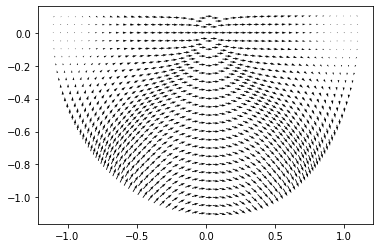

In [39]:
#building velocity field 
pi = 3.14159
#u_test = -np.cos(pi*Xc/2)*Zc
#v_test = pi*np.sin(pi*Xc/2)*(1-Zc**2)/4

#u_test = np.cos(pi*X_buffer/2)
#v_test = Z_buffer*np.sin(pi*X_buffer/2)*pi/2
#u_test = Z_buffer
#v_test = X_buffer*0 + 1
u_test = np.cos(pi*X_buffer/2)
v_test = Z_buffer*np.sin(pi*X_buffer/2)*pi/2
plt.quiver(X_buffer,Z_buffer,u_test,v_test)
#plt.plot(Xc,Zc,'.',color = 'r')

In [33]:
def phi(x_i,z_i,x_j,z_j,a):
    eps = 1e-6
    r = np.sqrt((x_i-x_j)**2 + (z_i-z_j)**2)
    
    return np.exp(-(a*r)**2)

In [34]:
def nabla2(xi,zi,xj,zj,a):
    eps = 1e-6
    return 4*a**2*(a**2*(xi - xj)**2 + a**2*(zi - zj)**2 - 1)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

In [35]:
def dphidx(xi,zi,xj,zj,a):
    return 2*a**2*(-xi + xj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

In [36]:
def dphidz(xi,zi,xj,zj,a):
    return 2*a**2*(-zi + zj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

In [37]:
#calculating features of u and v fields

#converting to galerkin representation:
a = 1/(5*dx)
N = X_buffer.shape[0]
phi_u = np.zeros((N,N))
nabla2_phi_u = np.zeros((N,N))
dphi_u_dx = np.zeros((N,N))
dphi_u_dz = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        phi_u[i,j] = phi(X_buffer[i,0],Z_buffer[i,0],X_buffer[j,0],Z_buffer[j,0],a)
        nabla2_phi_u[i,j] = nabla2(X_buffer[i,0],Z_buffer[i,0],X_buffer[j,0],Z_buffer[j,0],a)
        dphi_u_dx[i,j] = dphidx(X_buffer[i,0],Z_buffer[i,0],X_buffer[j,0],Z_buffer[j,0],a)
        dphi_u_dz[i,j] = dphidz(X_buffer[i,0],Z_buffer[i,0],X_buffer[j,0],Z_buffer[j,0],a)


u_j = np.linalg.solve(phi_u,u_test)
v_j = np.linalg.solve(phi_u,v_test)

nabla2_u = np.matmul(nabla2_phi_u,u_j)[0:n*m,:]
nabla2_v = np.matmul(nabla2_phi_u,v_j)[0:n*m,:]
dudx = np.matmul(dphi_u_dx,u_j)[0:n*m,:]
dudz = np.matmul(dphi_u_dz,u_j)[0:n*m,:]
dvdx = np.matmul(dphi_u_dx,v_j)[0:n*m,:]
dvdz = np.matmul(dphi_u_dz,v_j)[0:n*m,:]

In [ ]:
phi_q = np.zeros((n*m,n*m))
nabla2_phi_q = np.zeros((n*m,n*m))
dphi_q_dx = np.zeros((n*m,n*m))
dphi_q_dz = np.zeros((n*m,n*m))
for i in range(0,n*m):
    for j in range(0,n*m):
        phi_q[i,j] = phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        nabla2_phi_q[i,j] = nabla2(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        dphi_q_dx[i,j] = dphidx(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        dphi_q_dz[i,j] = dphidz(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)


u_j = np.linalg.solve(phi_u,u_test)
v_j = np.linalg.solve(phi_u,v_test)

nabla2_u = np.matmul(nabla2_phi_u,u_j)
nabla2_v = np.matmul(nabla2_phi_u,v_j)
dudx = np.matmul(dphi_u_dx,u_j)
dudz = np.matmul(dphi_u_dz,u_j)
dvdx = np.matmul(dphi_u_dx,v_j)
dvdz = np.matmul(dphi_u_dz,v_j)

In [ ]:
gov_mat = np.zeros((2*n*m, 2*n*m))
nabla2u = Xc*0 + 1

#setting up solution matrix:

#horizontal momentum
for i in range(0,m*n):
    for j in range(0,m*n):
        gov_mat[i,j] = nabla2_u[i,0]*phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        gov_mat[i,j+m*n] = dphidx(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)

#vertical momentum 
nabla2v = Xc*0 + 1
for i in range(0,m*n):
    for j in range(0,m*n):
        gov_mat[i+m*n,j] = nabla2_v[i,0]*phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)
        gov_mat[i+m*n,j+m*n] = dphidz(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0] ,a)